In [1]:
import env
import acquire
import prepare_bootcamp_readme
import requests as req
import pandas as pd
import numpy as np
import utilities as utils
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [2]:
bootcamp_readme_df = pd.read_csv(env.data_path + "coding_bootcamp_readme.csv")

In [3]:
bootcamp_readme_df = prepare_bootcamp_readme.prepare_bootcamp_readme_df(bootcamp_readme_df)

NaN values
     rows  columns
0       4        1
1      15        1
2      17        2
3      19        1
4      23        1
..    ...      ...
269   983        1
270   987        1
271   989        1
272   990        1
273   993        1

[274 rows x 2 columns]
--------------------------------
Empty values
   rows  columns
0   514        2
1   565        2
2   635        2
--------------------------------


In [4]:
bootcamp_readme_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451 entries, 0 to 997
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             451 non-null    object
 1   language         451 non-null    object
 2   readme_contents  451 non-null    object
dtypes: object(3)
memory usage: 14.1+ KB


## Explore

In [5]:
bootcamp_readme_df.language.value_counts()

JavaScript          184
Jupyter Notebook    157
Python               73
Java                 37
Name: language, dtype: int64

Web development languages seem to dominate repositores (Javascript, Java) with data science languages coming in second (Jupyter notebook and Python).

In [6]:
languages_df = pd.concat([bootcamp_readme_df.language.value_counts(), bootcamp_readme_df.language.value_counts(normalize=True)], axis=1)
languages_df.columns = ['count', 'percent']

In [7]:
print(f"Combined % of web dev languages:  {round(languages_df.loc[['JavaScript', 'Java']].percent.sum(), 4)}")
print(f"Combined % of data science languages:  {round(languages_df.loc[['Jupyter Notebook', 'Python']].percent.sum(), 4)}")

Combined % of web dev languages:  0.49
Combined % of data science languages:  0.51


In [8]:
# The dictionary entry for a language will hold the list of unique words in all the readme files
readme_words_by_language_dict = {}

for language in languages_df.index:
    all_readme_for_language = " ".join(bootcamp_readme_df[bootcamp_readme_df.language == language].readme_contents)
    
    readme_words_by_language_dict[language] = re.sub(r"[^\w\s]", "", all_readme_for_language).split()    

In [9]:
# Count the occurences of the words for each language
word_count_by_lanugage_dict = {}

for language in readme_words_by_language_dict.keys():
    word_count_by_lanugage_dict[language] = pd.Series(readme_words_by_language_dict[language]).value_counts()

In [10]:
# Make an entry in each dictionary for 'all_languages'
all_readme_text = " ".join(bootcamp_readme_df.readme_contents)

readme_words_by_language_dict['all_languages'] = re.sub(r"[^\w\s]", "", all_readme_text).split()

word_count_by_lanugage_dict['all_languages'] = pd.Series(readme_words_by_language_dict['all_languages']).value_counts()

In [11]:
word_counts_df = pd.concat(word_count_by_lanugage_dict.values(), axis=1, sort=False)\
.set_axis(word_count_by_lanugage_dict.keys(), axis=1, inplace=False)\
.fillna(0).apply(lambda s : s.astype(int))

In [12]:
word_counts_df.sort_values(by='all_languages', ascending=False).head(10)

,JavaScript,Jupyter Notebook,Python,Java,all_languages
9,159,267,452,58,936
de,599,196,69,40,904
python,9,589,282,0,880
bootcamp,207,287,141,32,667
1,299,159,95,75,628
data,88,400,120,20,628
e,342,123,33,21,519
code,249,131,108,20,508
use,246,121,96,18,481
2,206,153,73,45,477


The top 10 words in README files for all languages are:  
1. 9
1. de
1. python
1. data
1. bootcamp
1. 1
1. code
1. e
1. 2
1. use

* Are there any words that identify web dev languages from data science languages?

In [13]:
not_js_in_python = word_counts_df[word_counts_df.JavaScript == 0].sort_values(by='Python').tail(10)
not_js_in_jupyter = word_counts_df[word_counts_df.JavaScript == 0].sort_values(by='Jupyter Notebook').tail(10)

In [14]:
not_java_in_python = word_counts_df[word_counts_df.Java == 0].sort_values(by='Python').tail(10)
not_java_in_jupyter = word_counts_df[word_counts_df.Java == 0].sort_values(by='Jupyter Notebook').tail(10)

In [15]:
data_sci_words_df = pd.concat([not_java_in_jupyter, not_java_in_python, not_js_in_jupyter,\
                               not_js_in_python])

In [16]:
# Words usually found in data science README files, but not in web dev
data_sci_words_df.index.unique()

Index(['panda', 'neural', 'x', 'w', 'analysis', 'university', 'science',
       'jupyter', 'notebook', 'python', 'milvus', 'heroku', 'veri', 'track',
       'module', 'print', 'django', 'reward', 'function', 'cell',
       'computational', 'tensorflow', 'visualization', 'jezyku', 'anaconda',
       'pycharm', 'def', 'steering', 'selenium', 'race', 'deepracer', 'agent',
       'car', 'olarak'],
      dtype='object')

In [17]:
not_python_in_js = word_counts_df[word_counts_df.Python == 0].sort_values(by='JavaScript').tail(10)
not_jupyter_in_js = word_counts_df[word_counts_df['Jupyter Notebook'] == 0].sort_values(by='JavaScript').tail(10)

In [18]:
not_python_in_java = word_counts_df[word_counts_df.Python == 0].sort_values(by='Java').tail(10)
not_jupyter_in_java = word_counts_df[word_counts_df['Jupyter Notebook'] == 0].sort_values(by='Java').tail(10)

In [19]:
web_dev_words_df = pd.concat([not_jupyter_in_java, not_jupyter_in_js, not_python_in_java, not_python_in_js])

In [20]:
web_dev_words_df.index.unique()

Index(['xml', 'robolectric', 'odev', 'cordapp', 'genymotion', 'treasure',
       'expense', 'layout', 'checkpoint', 'android', 'altbr', 'aligncentera',
       'h3', 'var', 'hr', 'td', 'yarn', 'nodejs', 'id', 'npm', 'intent', 'com',
       'spring', 'aula', 'uma', 'desafio', 'na', 'em', 'projeto', 'um',
       'react'],
      dtype='object')

In [21]:
word_counts_df['web_dev_languages'] = word_counts_df.Java + word_counts_df.JavaScript

In [22]:
word_counts_df['data_sci_languages'] = word_counts_df['Jupyter Notebook'] + word_counts_df['Python']

In [23]:
word_counts_df['other_languages'] = word_counts_df.all_languages - word_counts_df.data_sci_languages - word_counts_df.web_dev_languages

In [24]:
word_counts_df

,JavaScript,Jupyter Notebook,Python,Java,all_languages,web_dev_languages,data_sci_languages,other_languages
de,599,196,69,40,904,639,265,0
e,342,123,33,21,519,363,156,0
1,299,159,95,75,628,374,254,0
javascript,267,1,3,1,272,268,4,0
code,249,131,108,20,508,269,239,0
...,...,...,...,...,...,...,...,...
awsbootcamp,0,0,0,1,1,1,0,0
httpsstartjhipstertechjdlstudio,0,0,0,1,1,1,0,0
activitieshttpdeveloperandroidcomguidecomponentsactivitieshtml,0,0,0,1,1,1,0,0
tolerant,0,0,0,1,1,1,0,0


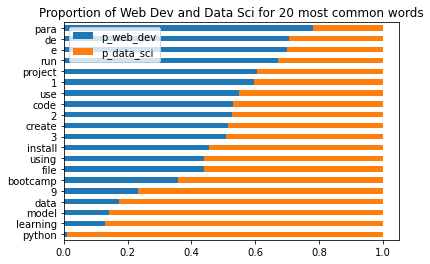

In [25]:
(word_counts_df.assign(p_web_dev=word_counts_df.web_dev_languages / word_counts_df.all_languages, \
                      p_data_sci=word_counts_df.data_sci_languages / word_counts_df.all_languages)\
.sort_values(by='all_languages')\
[['p_web_dev', 'p_data_sci']]\
.tail(20).sort_values('p_web_dev').plot.barh(stacked=True))

plt.title('Proportion of Web Dev and Data Sci for 20 most common words')
plt.legend(loc="best")
plt.show()

* 'Python', 'learning', and 'data'  overwhelmingly in data science repositories
* 'e', 'de', and 'para' are present web dev repositories
    * Are these fragments of HTML elements or CSS selectors?

(-0.5, 799.5, 999.5, -0.5)

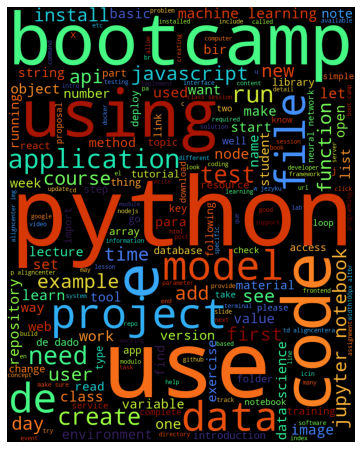

In [26]:
img = WordCloud(background_color="black", height=1000, width=800, colormap="turbo")\
    .generate(" ".join(readme_words_by_language_dict['all_languages']))

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")

In [27]:
web_dev_word_list = \
list(set(readme_words_by_language_dict['Java'] + readme_words_by_language_dict['JavaScript']))

In [28]:
data_sci_word_list = list(set(readme_words_by_language_dict['Jupyter Notebook'] + readme_words_by_language_dict['Python']))

(-0.5, 799.5, 999.5, -0.5)

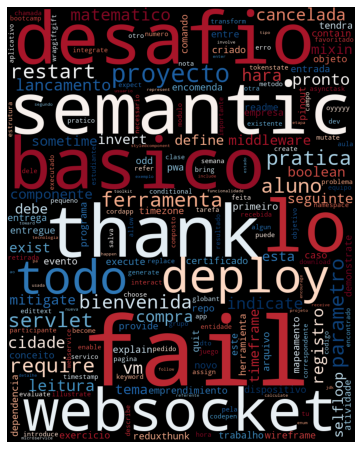

In [29]:
img = WordCloud(background_color="black", height=1000, width=800, colormap="RdBu")\
    .generate(" ".join(web_dev_word_list))

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")

(-0.5, 799.5, 999.5, -0.5)

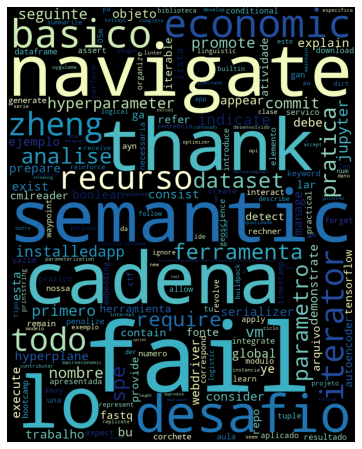

In [30]:
img = WordCloud(background_color="black", height=1000, width=800, colormap="YlGnBu")\
    .generate(" ".join(data_sci_word_list))

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")

In [31]:
# Bigrams
top_20_webdev_bigrams = pd.Series(nltk.ngrams(web_dev_word_list, 2)).value_counts().head(20)
top_20_webdev_bigrams.head()

(hrefhttpsgithubcompleitersondesafiosbootcampsdioblobmasterjavafundamentos20aritmc3a9ticos20em20javaanalisenumerosjavaanalise, different)    1
(pinning, ahead)                                                                                                                             1
(aided, injecao)                                                                                                                             1
(organizacao, styled)                                                                                                                        1
(hrefdocsdocsanbspnbspnbspnbspnbspnbsp, reactappfacebookid)                                                                                  1
dtype: int64

In [32]:
# Bigrams
top_20_datasci_bigrams = pd.Series(nltk.ngrams(data_sci_word_list, 2)).value_counts().head(20)
top_20_datasci_bigrams.head()

(springer, econhttpsgithubcomopensourceeconbootcamp2019treemastereconweek3)         1
(interact, bystander)                                                               1
(ztdlbootcamp, mathilde)                                                            1
(httpss3amazonawscom4dndcicpublichicdataanalysisbootcampuntr20000cool, printa15)    1
(downloaded, oddes)                                                                 1
dtype: int64

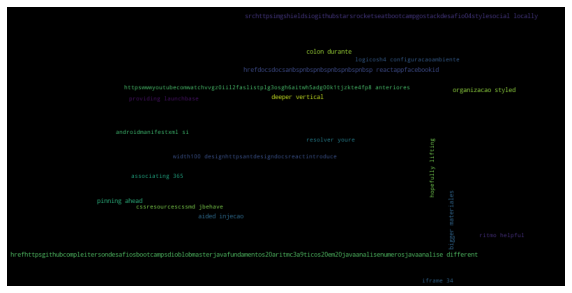

In [33]:
# Generate wordcloud following example from curriculum
data = {k[0] + ' ' + k[1]: v for k, v in top_20_webdev_bigrams.to_dict().items()}
img = WordCloud(background_color='black', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

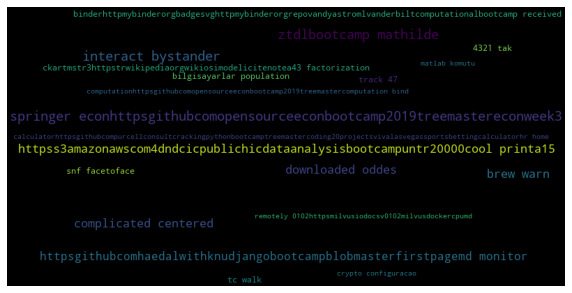

In [34]:
# Generate wordcloud following example from curriculum
data = {k[0] + ' ' + k[1]: v for k, v in top_20_datasci_bigrams.to_dict().items()}
img = WordCloud(background_color='black', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [35]:
word_list = pd.Series(readme_words_by_language_dict['all_languages'])

# Make dataframe with raw count and frequencies
word_freq_df = (pd.DataFrame({'raw_count': word_list.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

word_freq_df.sort_values(by='frequency', ascending=False).head(20)

,raw_count,frequency,augmented_frequency
9,936,0.008533,1.000000
de,904,0.008241,0.965812
python,880,0.008022,0.940171
bootcamp,667,0.006081,0.712607
data,628,0.005725,0.670940
1,628,0.005725,0.670940
e,519,0.004731,0.554487
code,508,0.004631,0.542735
use,481,0.004385,0.513889
2,477,0.004348,0.509615


In [36]:
# Calculate IDF
def idf(word, document_series):
    n_occurences = sum([1 for doc in document_series if word in doc])
    
    return np.log(len(document_series) / n_occurences)

In [37]:
word_freq_df = word_freq_df.reset_index()
word_freq_df = word_freq_df.rename(columns={'index' : 'word'})

In [38]:
word_freq_df['idf'] = word_freq_df.word.apply(idf, document_series=bootcamp_readme_df.readme_contents)

word_freq_df.sort_values(by='idf', ascending=False).head(20)

,word,raw_count,frequency,augmented_frequency,idf
10284,threadshttpdeveloperandroidcomguidecomponentsp...,1,0.000009,0.001068,6.111467
10162,introductorylevel,1,0.000009,0.001068,6.111467
10150,gangplank,1,0.000009,0.001068,6.111467
10151,mehttpsgithubcomnathinhaigtifullstackbootcampb...,1,0.000009,0.001068,6.111467
10152,reactcreateclass,1,0.000009,0.001068,6.111467
10153,scriptshttpsdocsnpmjscommiscscripts,1,0.000009,0.001068,6.111467
10154,pleiterson,1,0.000009,0.001068,6.111467
10155,hamilton,1,0.000009,0.001068,6.111467
10156,dividir,1,0.000009,0.001068,6.111467
15852,guvenlik,1,0.000009,0.001068,6.111467


In [39]:
word_freq_df['tf_idf'] = word_freq_df.frequency * word_freq_df.idf

word_freq_df.sort_values(by='tf_idf', ascending=False).head(20)

,word,raw_count,frequency,augmented_frequency,idf,tf_idf
2,python,880,0.008022,0.940171,1.114255,0.008939
0,9,936,0.008533,1.000000,0.907461,0.007743
19,model,301,0.002744,0.321581,1.937080,0.005315
4,data,628,0.005725,0.670940,0.924082,0.005290
21,notebook,286,0.002607,0.305556,1.834801,0.004784
29,javascript,272,0.002480,0.290598,1.921813,0.004765
20,function,288,0.002625,0.307692,1.807402,0.004745
12,using,379,0.003455,0.404915,1.323976,0.004574
11,project,419,0.003820,0.447650,1.162707,0.004441
7,code,508,0.004631,0.542735,0.952412,0.004411


In [40]:
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(bootcamp_readme_df.readme_contents)
y = bootcamp_readme_df.language

In [41]:
vector_bootcamp_readme_df = pd.DataFrame(X, y)
vector_bootcamp_readme_df = vector_bootcamp_readme_df.reset_index()
vector_bootcamp_readme_df = bootcamp_readme_df.rename(columns={'index' : 'label', 0 : 'text'})

In [42]:
vector_bootcamp_readme_df.language.value_counts()

JavaScript          184
Jupyter Notebook    157
Python               73
Java                 37
Name: language, dtype: int64

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [44]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=.3)

In [45]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

In [46]:
lm = LogisticRegression(class_weight="balanced").fit(X_train, y_train)

In [47]:
train['predicted'] = lm.predict(X_train)
validate['predicted'] = lm.predict(X_validate)
test['predicted'] = lm.predict(X_test)

In [48]:
# Training sample
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 98.41%
---
Confusion Matrix
actual            Java  JavaScript  Jupyter Notebook  Python
predicted                                                   
Java                22           1                 0       0
JavaScript           0          94                 3       0
Jupyter Notebook     0           0                84       0
Python               0           0                 0      48
---
                  precision    recall  f1-score   support

            Java       0.96      1.00      0.98        22
      JavaScript       0.97      0.99      0.98        95
Jupyter Notebook       1.00      0.97      0.98        87
          Python       1.00      1.00      1.00        48

        accuracy                           0.98       252
       macro avg       0.98      0.99      0.98       252
    weighted avg       0.98      0.98      0.98       252



In [49]:
# Training sample
print('Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate.predicted, validate.actual))
print('---')
print(classification_report(validate.actual, validate.predicted))

Accuracy: 77.78%
---
Confusion Matrix
actual            Java  JavaScript  Jupyter Notebook  Python
predicted                                                   
Java                 2           0                 0       0
JavaScript           3          40                 5       2
Jupyter Notebook     2           2                36       5
Python               1           3                 1       6
---
                  precision    recall  f1-score   support

            Java       1.00      0.25      0.40         8
      JavaScript       0.80      0.89      0.84        45
Jupyter Notebook       0.80      0.86      0.83        42
          Python       0.55      0.46      0.50        13

        accuracy                           0.78       108
       macro avg       0.79      0.61      0.64       108
    weighted avg       0.78      0.78      0.76       108



In [50]:
# Test sample
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 73.63%
---
Confusion Matrix
actual            Java  JavaScript  Jupyter Notebook  Python
predicted                                                   
Java                 2           1                 0       0
JavaScript           5          38                 4       4
Jupyter Notebook     0           1                23       4
Python               0           4                 1       4
---
                  precision    recall  f1-score   support

            Java       0.67      0.29      0.40         7
      JavaScript       0.75      0.86      0.80        44
Jupyter Notebook       0.82      0.82      0.82        28
          Python       0.44      0.33      0.38        12

        accuracy                           0.74        91
       macro avg       0.67      0.58      0.60        91
    weighted avg       0.72      0.74      0.72        91

